--------------------
## Scenario building of the lake level


In [9]:
# load the packages
import xarray as xr
import pandas as pd
import numpy  as np
from datetime import date
from datetime import datetime
import os
import shutil
import glob
#import datetime #import date
import matplotlib.pyplot  as plt
import matplotlib
from ipynb.fs.full.Untitled2 import save_netcdf
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 20}
# matplotlib.rcs('font', **font)
plt.rc('font', **font)


In [222]:
# # creating the target volumes for the lake Difenbaker
# df = pd.read_csv('../data/HYDAT/05HF003_level.csv') # elevation record of lake diefenbaker

# # set the date as the index
# df['DATE'] = pd.to_datetime(df['DATE'])
# df = df.set_index('DATE')
# df = df.loc['2013-01-01':'2013-12-31']
# df.plot()


# #
# df_scenarios = df.copy()

# # create the backward role of delta_time
# lead_times = [0,1,2,3,4,5]
# normalization_times = [1,2,3,4,5,6,7,8,9,10,]
# ele_steps = [0,0.5,1,1.5,2]


# #
# date_of_interest = pd.to_datetime('2013-06-24')
# delta = df.loc[date_of_interest,'05HF003'] - \
#         df.loc[date_of_interest-pd.Timedelta(days=1),'05HF003']

# for lead_time in lead_times:
#     for normalization_time in normalization_times:
#         for ele_step in ele_steps:

#             # craete the column name
#             column_name = 'scenario_' + str(ele_step) +'_'+ str(lead_time)+ '_' + str(normalization_time)
#             df_scenarios [column_name] = np.nan
#             print(column_name)
#             #print(df_scenarios)

#             # shift back to the lead time from 24 of June
#             df_scenarios.loc[:date_of_interest-pd.Timedelta(days=lead_time),column_name] = \
#             df_scenarios.loc[:date_of_interest,'05HF003'].shift(-1*lead_time)

#             # create the model continuation
#             df_scenarios.loc[date_of_interest-pd.Timedelta(days=lead_time):date_of_interest,column_name] = \
#             df_scenarios.loc[date_of_interest-pd.Timedelta(days=lead_time):date_of_interest,column_name]
#             for n in np.arange(lead_time+1):
#                 df_scenarios.loc[date_of_interest-pd.Timedelta(days=n),column_name] = \
#                 df_scenarios.loc[date_of_interest-pd.Timedelta(days=lead_time),column_name] + delta * (lead_time-n) 

#             # reduce elevation
#             df_scenarios.loc[:date_of_interest,column_name] = df_scenarios.loc[:date_of_interest,column_name] - ele_step

#             #
#             df_scenarios.loc[date_of_interest:,column_name] = df_scenarios.loc[date_of_interest,column_name]
#             df_scenarios['temp'] = np.nan
#             df_scenarios.loc[:date_of_interest,'temp'] = 1
#             df_scenarios.loc[date_of_interest+pd.Timedelta(days=normalization_time):,'temp'] = 0
#             df_scenarios['temp'] = df_scenarios['temp'].interpolate()
#             df_scenarios['temp'] = df_scenarios['temp']**3.0

#             df_scenarios[column_name] = (df_scenarios['temp'])*df_scenarios[column_name]+(1-df_scenarios['temp'])*df_scenarios['05HF003']

#             df_scenarios = df_scenarios.drop(columns='temp')

# # craeting the varibales
# df_scenarios_24 = df_scenarios.copy()
# df_scenarios_24.columns = [col + '_24' if col.startswith('scenario') else col for col in df_scenarios_24.columns]

# df_scenarios_25 = df_scenarios.copy()
# df_scenarios_25 = df_scenarios_25.drop(columns='05HF003')
# df_scenarios_25.columns = [col + '_25' if col.startswith('scenario') else col for col in df_scenarios_25.columns]
# df_scenarios_25 = df_scenarios_25.shift(1)

# df_scenarios_23 = df_scenarios.copy()
# df_scenarios_23 = df_scenarios_23.drop(columns='05HF003')
# df_scenarios_23.columns = [col + '_23' if col.startswith('scenario') else col for col in df_scenarios_23.columns]
# df_scenarios_23 = df_scenarios_23.shift(-1)

# df_scenarios_22 = df_scenarios.copy()
# df_scenarios_22 = df_scenarios_22.drop(columns='05HF003')
# df_scenarios_22.columns = [col + '_22' if col.startswith('scenario') else col for col in df_scenarios_22.columns]
# df_scenarios_22 = df_scenarios_22.shift(-2)

# df_scenarios_26 = df_scenarios.copy()
# df_scenarios_26 = df_scenarios_26.drop(columns='05HF003')
# df_scenarios_26.columns = [col + '_26' if col.startswith('scenario') else col for col in df_scenarios_26.columns]
# df_scenarios_26 = df_scenarios_26.shift(+2)

# df_scenarios = pd.concat([df_scenarios_22, df_scenarios_23, df_scenarios_24, df_scenarios_25, df_scenarios_26], axis=1)


# # plotting
# print(df_scenarios.columns)
# df_scenarios['2013-06-15':'2013-07-10'].plot(figsize=(20,10))
# plt.grid(which='both')
# plt.gca().get_legend().remove()
# plt.ylabel('Elevation of \n lake Diefenbaker [m]')


In [224]:
def shift_target_time (df, target_datetime, shifted_datetime, start_datetime, end_datetime):
    
    # shift before shifted_datetime
    df1 = shift_target_time_one_side (df, target_datetime, shifted_datetime, start_datetime)
    df2 = shift_target_time_one_side (df1, target_datetime, shifted_datetime, end_datetime)
    
    return df2


def shift_target_time_one_side (df, target_datetime, shifted_datetime, side_datetime):
    
    """
    This function get a time series, start and end time and
    compress or elongate withing a given new date and time and pass the dataframe out
    """
    
    if (datetime.strptime(target_datetime, '%Y-%m-%d %H:%M:%S') < \
    datetime.strptime(side_datetime, '%Y-%m-%d %H:%M:%S')) and \
    (datetime.strptime(shifted_datetime, '%Y-%m-%d %H:%M:%S') < \
    datetime.strptime(side_datetime, '%Y-%m-%d %H:%M:%S')):
        
        # slice the dataframe within the start and end time
        df_slice = df [target_datetime:side_datetime]

        # upsample to minute frequency
        df_resampled = df_slice.resample('T').asfreq()

        # interpolate missing values
        df_interpolated = df_resampled.interpolate(method='linear')

        # create time index of the rescale time frame
        time_index = pd.date_range(start=shifted_datetime, end=side_datetime)
        
    elif (datetime.strptime(target_datetime, '%Y-%m-%d %H:%M:%S') > \
    datetime.strptime(side_datetime, '%Y-%m-%d %H:%M:%S')) and \
    (datetime.strptime(shifted_datetime, '%Y-%m-%d %H:%M:%S') > \
    datetime.strptime(side_datetime, '%Y-%m-%d %H:%M:%S')):
        
        # slice the dataframe within the start and end time
        df_slice = df [side_datetime:target_datetime]

        # upsample to minute frequency
        df_resampled = df_slice.resample('T').asfreq()

        # interpolate missing values
        df_interpolated = df_resampled.interpolate(method='linear')

        # create time index of the rescale time frame
        time_index = pd.date_range(start=side_datetime, end=shifted_datetime)
        
    else:
        
        print('cannot decide the case')
    
    # get the location of resampled of the time series based on the frequency of the new two date and time
    space = np.linspace(0, len(df_interpolated)-1, len(time_index))
    space = space.astype(int)
    
    # get the interpolated values and reindex them based on new start and end time for rescale
    df_interpolated_reindex = df_interpolated.iloc[space]
    df_interpolated_reindex.index = time_index
    mask = ~df.index.isin(df_interpolated_reindex.index)
    df = df.loc[mask] 
    df = pd.concat ([df, df_interpolated_reindex])
    df = df.sort_index()

    return df
    
def shift_value_target_time (df, target_time, start_time, end_time, scale):
    
    #
    df_temp = df.copy()
    df_temp ['w'] = np.nan
    df_temp.loc[target_time,'w'] = 1
    df_temp.loc[:start_time,'w'] = 0
    df_temp.loc[end_time:,  'w'] = 0
    
    df_temp = df_temp.interpolate()
    
    
    for column in df.columns:
        df.loc[:,column]  = (1-df_temp.loc[:,'w']) * df.loc[:,column] + \
                             df_temp.loc[:,'w'] * (df.loc[:,column] - scale)
    
    
    return df
    
def shift_value_target_one_side (df, target_time, start_time, scale, power):
    
    #
    df_temp = df.copy()
    df_temp ['w'] = np.nan
    df_temp.loc[:start_time, 'w'] = 1
    df_temp.loc[target_time:,'w'] = 0
    
    
    df_temp = df_temp.interpolate()
    
    df_temp ['w'] = df_temp ['w']**power
    
    
    for column in df.columns:
        df[column]  = (1-df_temp ['w']) * df[column]  + df_temp ['w'] * (df[column]  - scale)
    
    return df
    
    
df = pd.read_csv('../data/HYDAT/05HF003_level.csv') # elevation record of lake diefenbaker

# set the date as the index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df = df.loc['2013-06-01':'2013-07-31']


lowest_level_dates = [22,23,24,25,26]

resume_level_dates = [22,23,24,25,26,27,28,29,30]

start_level_dates = [15, 16, 17,18,19,20,21,22]

level_decreases = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

lowest_level_date_target = [24]

combination = np.array(np.meshgrid(start_level_dates, lowest_level_dates, resume_level_dates, level_decreases, lowest_level_date_target)).T.reshape(-1,5)

scenarios = pd.DataFrame(combination, columns = ['start_level_dates', 'lowest_level_dates',\
                                                 'resume_level_dates', 'level_decreases',\
                                                 'target_date'])
#
scenarios = scenarios[scenarios['start_level_dates'] < scenarios['lowest_level_dates']]
scenarios = scenarios[scenarios['lowest_level_dates'] < scenarios['resume_level_dates']]

#
scenarios = scenarios[scenarios['start_level_dates'] < scenarios['target_date']]
scenarios = scenarios[scenarios['target_date'] < scenarios['resume_level_dates']]


scenarios = scenarios.reset_index()

df_scenarios = df.copy()

for index, row in scenarios.iterrows():
    
    start_level_date = "{:.0f}".format(row.start_level_dates)
    resume_level_date = "{:.0f}".format(row.resume_level_dates)
    lowest_level_date = "{:.0f}".format(row.lowest_level_dates)
    level_decrease = row.level_decreases
    
    
    df1 = shift_target_time (df,\
                            '2013-06-24 00:00:00',\
                            '2013-06-'+str(lowest_level_date)+' 00:00:00',\
                            '2013-06-'+str(start_level_date)+' 00:00:00',\
                            '2013-06-'+str(resume_level_date)+' 00:00:00')


    df2 = shift_value_target_time (df1,\
                                  '2013-06-'+str(lowest_level_date)+' 00:00:00',\
                                  '2013-06-'+str(start_level_date)+' 00:00:00',\
                                  '2013-06-'+str(resume_level_date)+' 00:00:00',\
                                  level_decrease)
    
    #
    column_name = 'scenario_'+str(start_level_date)+'_'+str(lowest_level_date)+'_'+str(resume_level_date)+'_'+str(level_decrease)
    df_scenarios [column_name] = df2['05HF003']

print(len(df_scenarios.columns))
df_scenarios



1471


,05HF003,scenario_15_22_25_0.0,scenario_15_23_25_0.0,scenario_15_24_25_0.0,scenario_16_22_25_0.0,scenario_16_23_25_0.0,scenario_16_24_25_0.0,scenario_17_22_25_0.0,scenario_17_23_25_0.0,scenario_17_24_25_0.0,...,scenario_20_26_30_1.5,scenario_21_22_30_1.5,scenario_21_23_30_1.5,scenario_21_24_30_1.5,scenario_21_25_30_1.5,scenario_21_26_30_1.5,scenario_22_23_30_1.5,scenario_22_24_30_1.5,scenario_22_25_30_1.5,scenario_22_26_30_1.5
DATE,,,,,,,,,,,,,,,,,,,,,
2013-06-01,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,...,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001,553.151001
2013-06-02,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,...,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019,553.244019
2013-06-03,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,...,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003,553.328003
2013-06-04,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,...,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011,553.424011
2013-06-05,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,...,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972,553.508972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-27,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,...,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986,556.510986
2013-07-28,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,...,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997,556.533997
2013-07-29,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,...,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006,556.544006


-----------
## Creating the target storage from the level

                 05HF003  scenario_15_22_25_0.0  scenario_15_23_25_0.0  \
DATE                                                                     
2013-06-01  7.867204e+09           7.867204e+09           7.867204e+09   
2013-06-02  7.902327e+09           7.902327e+09           7.902327e+09   
2013-06-03  7.934040e+09           7.934040e+09           7.934040e+09   
2013-06-04  7.970292e+09           7.970292e+09           7.970292e+09   
2013-06-05  8.002373e+09           8.002373e+09           8.002373e+09   
...                  ...                    ...                    ...   
2013-07-27  9.212423e+09           9.212423e+09           9.212423e+09   
2013-07-28  9.222106e+09           9.222106e+09           9.222106e+09   
2013-07-29  9.226318e+09           9.226318e+09           9.226318e+09   
2013-07-30  9.230530e+09           9.230530e+09           9.230530e+09   
2013-07-31  9.234742e+09           9.234742e+09           9.234742e+09   

            scenario_15_24_25_0.0  sc

Text(0, 0.5, 'Storage of \n lake Diefenbaker [m3]')

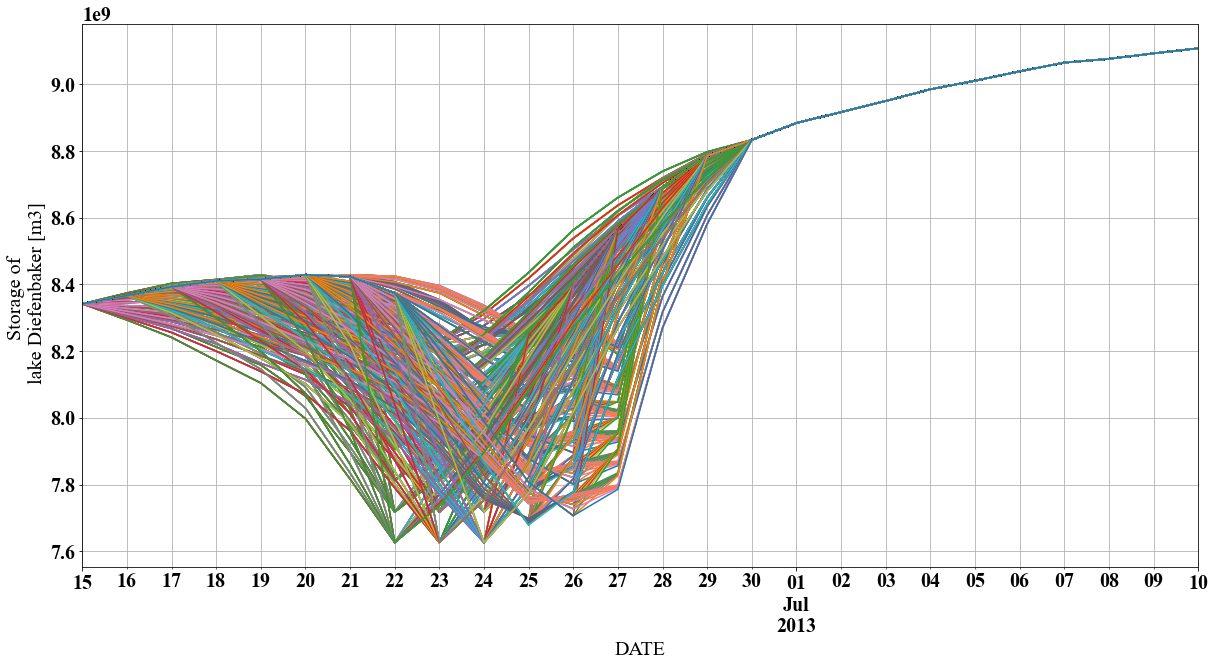

In [225]:
# load the elevation storage relationship
ele_str = pd.read_csv('../data/Elevation_Storage/Storage_Elevation_Diefenbaker.csv')

df_scenarios_storage = df_scenarios.copy()

for column in df_scenarios_storage.columns:
    df_scenarios_storage [column] =    np.interp(df_scenarios_storage [column], ele_str['Elevation(m)'], ele_str['Storage(m^3)'])
print(df_scenarios_storage)

df_scenarios_storage = df_scenarios_storage.loc['2013-06-01':'2013-07-31']
df_scenarios_storage.to_csv('../data/Storage_ensemble_Scenarios.csv')

# plotting
df_scenarios_storage['2013-06-15':'2013-07-10'].plot(figsize=(20,10))
plt.grid(which='both')
plt.gca().get_legend().remove()
plt.ylabel('Storage of \n lake Diefenbaker [m3]')

